Cristian Villazhannay  
ME 470  
9 May 2023

### Part A
The fully discretized finite difference equation is:

$$
\frac{T^{n+1} - T^{n}}{\Delta t} = D \left[ 
    \frac{ u_{i + 1, j    , z    } - 2 u_{i  , j  , z  } + u_{i - 1, j    , z    }}{\Delta X^{2}} + 
    \frac{ u_{i    , j + 1, z    } - 2 u_{i  , j  , z  } + u_{i    , j - 1, z    }}{\Delta Y^{2}} + 
    \frac{ u_{i    , j    , z + 1} - 2 u_{i  , j  , z  } + u_{i    , j    , z - 1}}{\Delta Z^{2}}
\right] 
$$

### Part B

The indexing scheme that I am using a local level is:

```C++ 
for (int k = 1; k < zSize - 1; ++k) //z-index
	{
	  for (int j = 1; j < ySize - 1; ++j) //y-index
	  {
	    for (int i = 1; i < xSize - 1; ++i) //x-index
	    {
	    	u[(xSize * ySize) * (k    ) + xSize * (j    ) + (i    )];
        }
      }
    }
```
MPI saves memory contiguously first in the x-direction (column-wise), the y-direction (row-wise), and then the z-direction (depth-wise). This schema helps convert the 3D data into a single array.  

This is possible since the index of $y$ increases the flat index by a factor of `xSize` because each row has *x* elements.  
Likewise, the $z$ index increases the flat index by a factor of `xSize * ySize` because there are *x \* y* elements in each plane of the cube.  
This allows us to store the memory in a flat array the way MPI would store it contiguously into memory.

### Part C
The derived data types that I made for the XY, YZ, and XZ plane are:
```C++
  MPI_Datatype XZ, YZ, XY; 

  //This can be contiguous since the MPI can read the data across the 
  //X row then up the Y rows.
  MPI_Type_contiguous(xSize * ySize, MPI_DOUBLE, &XY);


  //Note that for these datatypes, the count * blocklength should be equal to the
  //number of elements in the desired plane.

  //Creation of the YZ datatype. This will be a vector type that simply 
  //reads up the column by skipping up through the xSize columns.
  MPI_Type_vector(zSize * ySize,     1,         xSize, MPI_DOUBLE, &YZ);

  //Creation of the XZ datatype. This will be a vector type that skips 
  //up the entirity of the XZ plane to get back to the base row. 
  MPI_Type_vector(zSize, xSize, xSize * ySize, MPI_DOUBLE, &XZ);

  //Don't forget to commit your changes to the actual variable.
  MPI_Type_commit(&XY);
  MPI_Type_commit(&YZ);
  MPI_Type_commit(&XZ);
```


### Part D 
Output and plot the the temperature at $x,y,z = (0.5, 0.5, 0.5)$ as a function of time, $ dt. $

The final value of x, y, z at (0.5, 0.5, 0.5) in serial is 0.53937112


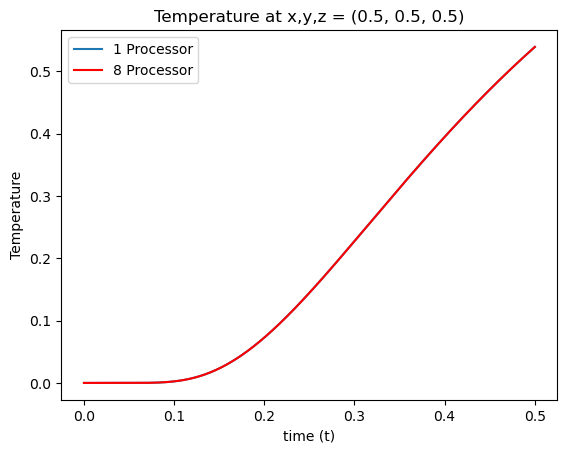

In [2]:
##Import our packages
import numpy as np
import matplotlib.pyplot as plt

#Import our data from the midpoints.
time = np.linspace(0,0.5,5000)
serial = np.loadtxt('parallelmiddle.dat')
parallel = np.loadtxt('serialmiddle.dat')

#Plot our data. 
fig, axs = plt.subplots()
axs.plot(time,serial, label="1 Processor")
axs.plot(time,parallel, color= 'red', label="8 Processor")
axs.set(xlabel='time (t)', ylabel='Temperature',
       title='Temperature at x,y,z = (0.5, 0.5, 0.5)')
axs.legend()

print("The final value of x, y, z at (0.5, 0.5, 0.5) in serial is", serial[-1])

### Part E 
The serial and parallel data both output a final value of 0.53937112. This can be further verified by taking the value straight from the input .dat files, which we've done below.	

In [3]:
fs_val = serial[-1]
fp_val = parallel[-1]
print("The final value of x, y, z at (0.5, 0.5, 0.5) in serial is", fs_val)
print("The final value of x, y, z at (0.5, 0.5, 0.5) in parallel is", fp_val)

The final value of x, y, z at (0.5, 0.5, 0.5) in serial is 0.53937112
The final value of x, y, z at (0.5, 0.5, 0.5) in parallel is 0.53937112


### Part F
Plot a colormap or contour plot of the $z = 0.5$ plane at $t = 0.5$. 

Text(0.5, 0.92, '1 Processor')

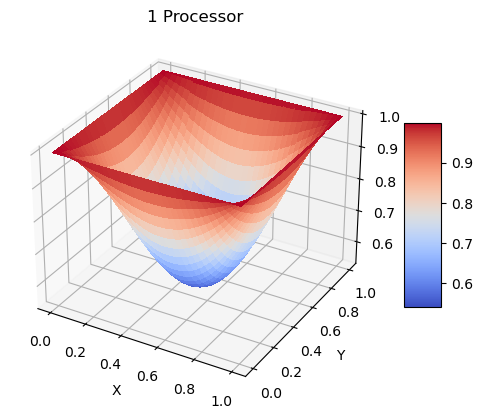

In [4]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

serial_z = np.loadtxt('serialpoisson2D.dat')

#Make Data 
nx, ny = 100, 100
Lx, Ly = 1, 1
nnx = nx + 1
nny = ny + 1

u = serial_z[:,2].reshape(nnx, nny).T
x = np.linspace(0, Lx, nnx)
y = np.linspace(0, Ly, nny)
x, y = np.meshgrid(x, y)

# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, u, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('1 Processor')


Text(0.5, 0.92, '8 Processors')

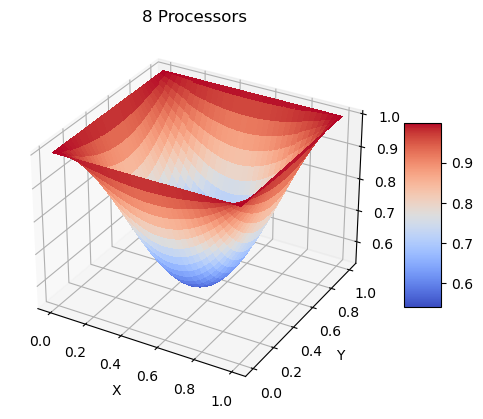

In [5]:
parallel_z = np.loadtxt('parallelpoisson2D.dat')

u = parallel_z[:,2].reshape(nnx, nny).T

# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, u, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('8 Processors')


### Part G
The `MPI_WTime()` command was used to compute and output the time taken for the time integration loop. This was repeated on on 1, 2, 4, 8, 16, and 32 processors so that a strong scaling study could be done. 

     Time    Processors
---------  ------------
129.104               1
 65.9645              2
 35.2809              4
 19.513               8
 12.206              16
  8.38057            32


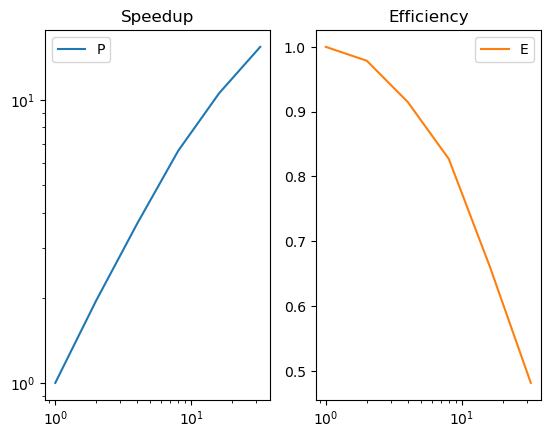

In [6]:
from tabulate import tabulate

col_names = ["Time", "Processors"]
proc = [1, 2, 4, 8, 16, 32]
time = [129.104, 65.9645, 35.2809, 19.513, 12.206, 8.38057]
data = []

for j in range(len(proc)):
    data.append([time[j], proc[j]])
    
print(tabulate(data, headers=col_names))

E = time.copy() #Efficiency
buff = time.copy()

#Calculate our time and E (speedup)
for i in range(len(time)):
    time[i] = buff[0]/buff[i]
    E[i] = buff[0]/ (proc[i] * buff[i])

#Plot speedup
fig, axs = plt.subplots(1,2)
axs[0].loglog(proc,time, label="P")
axs[0].set_title("Speedup")
axs[0].legend()

#Plotting the efficiency
axs[1].semilogx(proc,E, "tab:orange", label="E")
axs[1].set_title("Efficiency")
axs[1].legend()